In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import sklearn.ensemble
import sklearn.model_selection

from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [19]:
import pickle

In [4]:
!pip install lime
from lime.lime_tabular import LimeTabularExplainer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=28207afee018cbbad05fe1200285834960aaaf19b7876d825cdc74f9fd83b712
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


# Image Classification with LIME

## Training Image Classification Model

In [5]:
from skimage.color import gray2rgb, rgb2gray # sklearn-image
from skimage.util import montage # 일렬로 배열된 이미지를 커다란 사각형으로 재배열.
from sklearn.datasets import fetch_olivetti_faces

In [6]:
faces=fetch_olivetti_faces()

print(np.array(faces.images).shape) # 400개의 64x64 이미지이다.

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data
(400, 64, 64)


In [7]:
X_vec=np.stack([gray2rgb(iimg) for iimg in faces.images], 0) # 이미지를 컬러로 변환해 아래로 쌓는다.
y_vec=faces.target#.astype(np.uint8)

print('shape of X: ', X_vec.shape,'\n'+'shape of y: ', y_vec.shape)

shape of X:  (400, 64, 64, 3) 
shape of y:  (400,)


In [8]:
from keras.utils import to_categorical

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_vec, y_vec, train_size=0.8, stratify=y_vec)

y_train = to_categorical(y_train, num_classes=40)
y_test = to_categorical(y_test, num_classes=40)

y_train_num=np.argmax(y_train, axis=1)
y_test_num=np.argmax(y_test, axis=1)

In [9]:
from keras.models import Sequential
from keras.layers import MaxPooling2D
from keras.layers import Conv2D
from keras.layers import Activation, Dropout, Flatten, Dense

num_classes=40

# 모델 구조 정의
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=[64,64,3], padding='same')) #64,64,3
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))

model.add(Conv2D(64, (3, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 전결합층
model.add(Flatten())    # 벡터형태로 reshape
model.add(Dense(512))   # 출력
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes)) # 40개
model.add(Activation('softmax'))

# 모델 구축하기
model.compile(loss='categorical_crossentropy',   # 최적화 함수 지정
    optimizer='rmsprop',
    metrics=['accuracy'])
# 모델 확인
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 30, 30, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     7,373,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 40)             │        20,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 40)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,450,152 (28.42 MB)

 Trainable params: 7,450,152 (28.42 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
model.predict(X_train[0].reshape(1, 64, 64, 3))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


array([[0.01928265, 0.02321807, 0.02162408, 0.02064185, 0.02817473,
        0.02217283, 0.02629774, 0.02708497, 0.02628887, 0.0259632 ,
        0.02457467, 0.02250624, 0.0268692 , 0.02780484, 0.01899192,
        0.02269132, 0.01908524, 0.03513872, 0.02433415, 0.02034285,
        0.02526833, 0.02961543, 0.02189391, 0.02802442, 0.03259586,
        0.02335161, 0.03081837, 0.02499171, 0.02486176, 0.01991165,
        0.02595057, 0.02182812, 0.01904063, 0.02854772, 0.03217756,
        0.02883673, 0.03102934, 0.02829896, 0.0234407 , 0.01642849]],
      dtype=float32)

In [11]:
print(y_test.shape)
print(y_test[0])

(80, 40)
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [12]:
# from keras.callbacks import EarlyStopping
# from keras.callbacks import ModelCheckpoint

# mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)
# es = EarlyStopping(monitor='val_accuracy', verbose=1, patience=50)
# model.fit(X_train, y_train, epochs=500,validation_split=0.2,callbacks=[es,mc])

# # 모델 평가하기
# score = model.evaluate(X_test, y_test)
# print('accuracy=', score[1])

Epoch 1/500
6/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0333 - loss: 5.2838   

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 0.0331 - loss: 5.1358 - val_accuracy: 0.0312 - val_loss: 3.6934
Epoch 2/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.0100 - loss: 3.7216 - val_accuracy: 0.0156 - val_loss: 3.7299
Epoch 3/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0449 - loss: 3.7219     

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.0452 - loss: 3.7208 - val_accuracy: 0.0469 - val_loss: 3.6645
Epoch 4/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.0330 - loss: 3.6783 - val_accuracy: 0.0156 - val_loss: 3.6696
Epoch 5/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.0372 - loss: 3.6517 - val_accuracy: 0.0312 - val_loss: 3.6619
Epoch 6/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0554 - loss: 3.5841 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.0553 - loss: 3.5828 - val_accuracy: 0.0781 - val_loss: 3.6456
Epoch 7/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0585 - loss: 3.5527 - val_accuracy: 0.0781 - val_loss: 3.4796
Epoch 8/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.1594 - loss: 3.3634 - val_accuracy: 0.0000e+00 - val_loss: 4.6249
Epoch 9/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1300 - loss: 3.5591 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.1342 - loss: 3.5257 - val_accuracy: 0.4062 - val_loss: 2.9799
Epoch 10/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4778 - loss: 2.3267 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.4794 - loss: 2.3029 - val_accuracy: 0.4219 - val_loss: 2.2495
Epoch 11/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6220 - loss: 1.4890 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6219 - loss: 1.4853 - val_accuracy: 0.6250 - val_loss: 1.5423
Epoch 12/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7476 - loss: 1.0241 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.7473 - loss: 1.0161 - val_accuracy: 0.7969 - val_loss: 0.8843
Epoch 13/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8551 - loss: 0.5499 - val_accuracy: 0.7969 - val_loss: 0.8719
Epoch 14/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8992 - loss: 0.3861 - val_accuracy: 0.7188 - val_loss: 0.9155
Epoch 15/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9192 - loss: 0.2635

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9233 - loss: 0.2600 - val_accuracy: 0.9062 - val_loss: 0.3933
Epoch 16/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8777 - loss: 0.5327 - val_accuracy: 0.8750 - val_loss: 0.3900
Epoch 17/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9761 - loss: 0.1098 - val_accuracy: 0.8281 - val_loss: 0.6748
Epoch 18/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9631 - loss: 0.0772 - val_accuracy: 0.9062 - val_loss: 0.4403
Epoch 19/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9758 - loss: 0.0604 - val_accuracy: 0.9062 - val_loss: 0.4200
Epoch 20/500
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0325 

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 1.0000 - loss: 0.0332 - val_accuracy: 0.9219 - val_loss: 0.4243
Epoch 21/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 1.0000 - loss: 0.0100 - val_accuracy: 0.9219 - val_loss: 0.5240
Epoch 22/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9677 - loss: 0.0775 - val_accuracy: 0.8750 - val_loss: 0.4874
Epoch 23/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9708 - loss: 0.1042 - val_accuracy: 0.9062 - val_loss: 0.5181
Epoch 24/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9886 - loss: 0.0451 - val_accuracy: 0.8125 - val_loss: 0.9399
Epoch 25/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.9858 - loss: 0.0658 - val_accuracy: 0.8750 - val_loss: 0.7897
Epoch 26/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 1.0000 - loss: 0.0133 - val_accuracy: 0.9062 - val_loss: 0.6796
Epoch 27/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 1.0000 - loss: 0.0104 - val_accuracy: 0.8906 - val_loss: 0.58

In [ ]:
# from keras.models import load_model

# # 학습 완료 후 모델 저장
# model.save("./model/olivetti_cnn_model.keras")

In [ ]:
from keras.models import load_model
model = load_model("./model/olivetti_cnn_model.keras")

## LIME을 통한 설명 시작

In [15]:
from lime import lime_image # 이미지 모듈
from lime.wrappers.scikit_image import SegmentationAlgorithm # LIME이 사용할 수 있게.

explainer=lime_image.LimeImageExplainer()

In [16]:
segmenter=SegmentationAlgorithm('slic',
                               n_segments=100, #이미지 분할 조각 개수
                               compactness=1, # 유사한 파트를 합치는 함수, log scale, default : 10
                               sigma=1) # 스무딩 역할, 0과 1 사이의 float

In [ ]:
olivetti_test_index=0

exp=explainer.explain_instance(X_test[olivetti_test_index], #데이터하나
                              classifier_fn=model.predict,# 40 class의 확률 반환 (softmax)
                              top_labels=5, # 확률 기준 1-5위 분석
                               num_samples=1000,# 샘플링 공간
                              segmentation_fn=segmenter) # 이전에 lime의 형식에 맞게 래핑된 분할 알고리즘

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━

Text(0.5, 1.0, 'Show mask only')

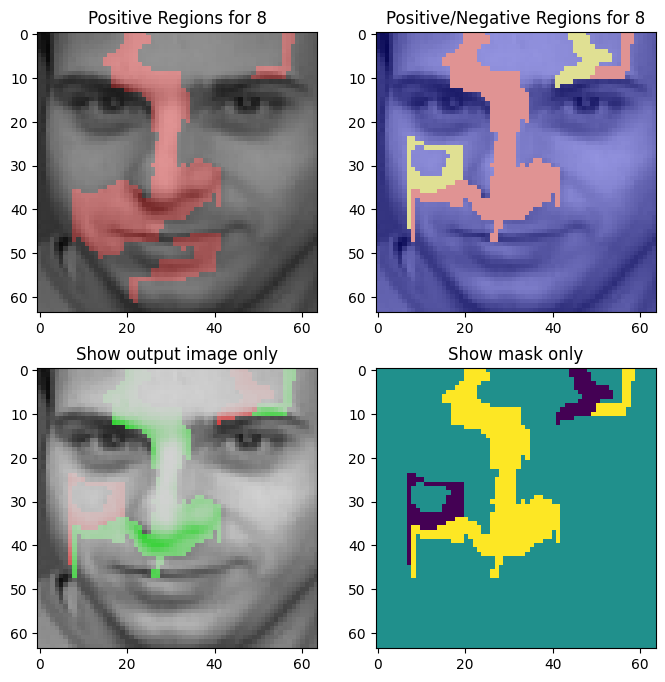

In [47]:
from skimage.color import label2rgb #

# 캔버스
fig, ((ax1, ax2), (ax3, ax4))=plt.subplots(2,2,figsize=(8,8))
ax=[ax1,ax2,ax3,ax4]
for i in ax:
    i.grid(False)
# 예측에 가장 도움되는 세그먼트만 출력
temp, mask=exp.get_image_and_mask(y_test_num[0],
                                 positive_only=True, # 설명 모델이 결과값을 가장 잘 설명하는 이미지 영역만 출력
                                 num_features=8, # 분할 영역의 크기
                                 hide_rest=False) # 이미지를 분류하는 데 도움이 되는 서브모듈 외의 모듈도 출력
# label2rgb : 형광색 마스킹
ax1.imshow(label2rgb(mask, temp, bg_label=0), interpolation='nearest')
ax1.set_title('Positive Regions for {}'.format(y_test_num[0]))

# 모든 세그먼트 출력
temp, mask=exp.get_image_and_mask(y_test_num[0],
                                 positive_only=False, # 설명 모델이 결과값을 가장 잘 설명하는 이미지 영역만 출력
                                 num_features=8, # 분할 영역의 크기
                                 hide_rest=False) # 이미지를 분류하는 데 도움이 되는 서브모듈 외의 모듈도 출력

ax2.imshow(label2rgb(4-mask, temp, bg_label=0), interpolation='nearest') # 역변환
ax2.set_title('Positive/Negative Regions for {}'.format(y_test_num[0]))

# 이미지만 출력
ax3.imshow(temp, interpolation='nearest')
ax3.set_title('Show output image only')

# 마스크만 출력
ax4.imshow(mask, interpolation='nearest') # 정수형 array.
ax4.set_title('Show mask only') # 정수형

In [48]:
from sklearn.metrics import classification_report
y_pred=model.predict(X_test)
y_pred_num=np.argmax(y_pred, axis=1)
print(classification_report(y_true=y_test_num, y_pred=y_pred_num))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      1.00      1.00         2
           2       0.50      0.50      0.50         2
           3       0.67      1.00      0.80         2
           4       1.00      0.50      0.67         2
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         2
           7       1.00      0.50      0.67         2
           8       0.67      1.00      0.80         2
           9       1.00      1.00      1.00         2
          10       1.00      1.00      1.00         2
          11       1.00      1.00      1.00         2
          12       0.00      0.00      0.00         2
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         2
          15       1.00      1.00      1.00         2
          16       1.00      1.00      1.00

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### 성능이 좋은 데이터에 대하여 LIME 출력

In [49]:
olivetti_test_index=6

exp=explainer.explain_instance(X_test[olivetti_test_index], #데이터하나
                              classifier_fn=model.predict,# 40 class의 확률 반환 (softmax)
                              top_labels=5, # 확률 기준 1-5위 분석
                               num_samples=1000,# 샘플링 공간
                              segmentation_fn=segmenter) # 이전에 lime의 형식에 맞게 래핑된 분할 알고리즘

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━

Text(0.5, 1.0, 'Show mask only')

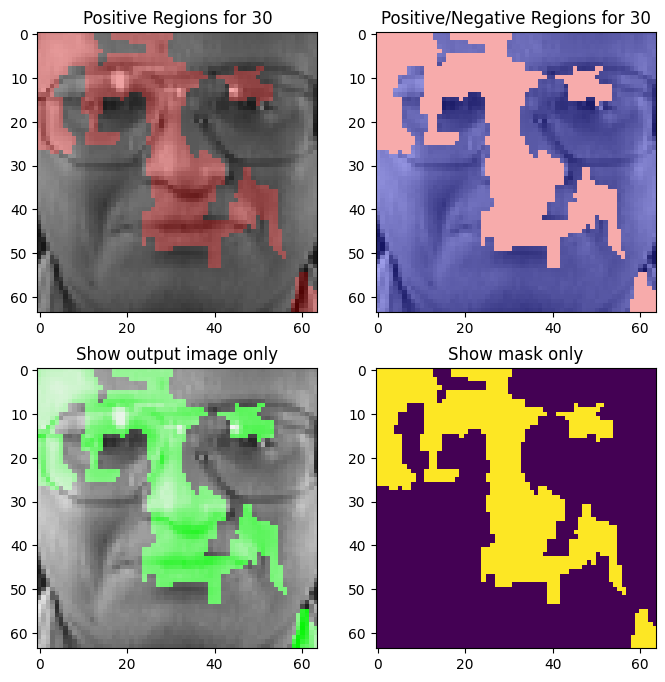

In [52]:
# 해당 인덱스의 실제 레이블
label = y_test_num[olivetti_test_index]  # 정답 클래스

# 캔버스
fig, ((ax1, ax2), (ax3, ax4))=plt.subplots(2,2,figsize=(8,8))
ax=[ax1,ax2,ax3,ax4]
for i in ax:
    i.grid(False)
# 예측에 가장 도움되는 세그먼트만 출력
temp, mask=exp.get_image_and_mask(label,
                                 positive_only=True, # 설명 모델이 결과값을 가장 잘 설명하는 이미지 영역만 출력
                                 num_features=8, # 분할 영역의 크기
                                 hide_rest=False) # 이미지를 분류하는 데 도움이 되는 서브모듈 외의 모듈도 출력
# label2rgb : 형광색 마스킹
ax1.imshow(label2rgb(mask, temp, bg_label=0), interpolation='nearest')
ax1.set_title('Positive Regions for {}'.format(label))

# 모든 세그먼트 출력
temp, mask=exp.get_image_and_mask(label,
                                 positive_only=False, # 설명 모델이 결과값을 가장 잘 설명하는 이미지 영역만 출력
                                 num_features=8, # 분할 영역의 크기
                                 hide_rest=False) # 이미지를 분류하는 데 도움이 되는 서브모듈 외의 모듈도 출력

ax2.imshow(label2rgb(4-mask, temp, bg_label=0), interpolation='nearest') # 역변환
ax2.set_title('Positive/Negative Regions for {}'.format(label))

# 이미지만 출력
ax3.imshow(temp, interpolation='nearest')
ax3.set_title('Show output image only')

# 마스크만 출력
ax4.imshow(mask, interpolation='nearest') # 정수형 array.
ax4.set_title('Show mask only') # 정수형

### 성능이 좋지 않은 데이터에 대하여 LIME 출력

기존 데이터의 target 잘못 예측한 클래스 중 하나인 2번째 클래스

In [61]:
np.where(y_test_num==2)

(array([18, 49]),)

In [83]:
test_idx=18
exp=explainer.explain_instance(X_test[test_idx], #데이터하나
                              classifier_fn=model.predict,# 40 class의 확률 반환 (softmax)
                              top_labels=5, # 확률 기준 1-5위 분석
                               num_samples=1000,# 샘플링 공간
                              segmentation_fn=segmenter) # 이전에 lime의 형식에 맞게 래핑된 분할 알고리즘

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━

In [81]:
print("LIME 설명 대상 클래스:", exp.top_labels)
label = exp.top_labels[0]
print(label)

LIME 설명 대상 클래스: [np.int64(39), np.int64(21), np.int64(3), np.int64(37), np.int64(28)]
39


Text(0.5, 1.0, 'Show mask only')

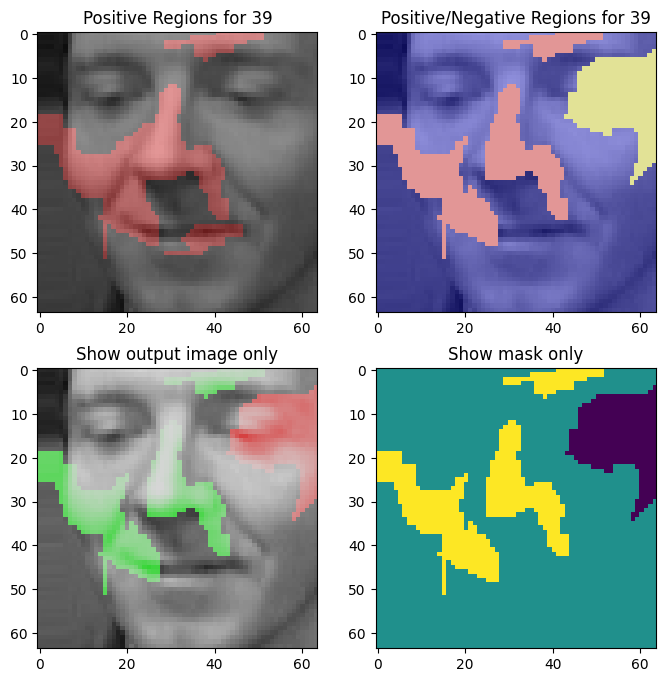

In [85]:
# 2번째 클래스가 39번째 데이터로 분류한 근거
label = exp.top_labels[0]

fig, ((ax1, ax2), (ax3, ax4))=plt.subplots(2,2,figsize=(8,8))
ax=[ax1,ax2,ax3,ax4]
for i in ax:
    i.grid(False)
# 예측에 가장 도움되는 세그먼트만 출력
temp, mask=exp.get_image_and_mask(label,
                                 positive_only=True, # 설명 모델이 결과값을 가장 잘 설명하는 이미지 영역만 출력
                                 num_features=8, # 분할 영역의 크기
                                 hide_rest=False) # 이미지를 분류하는 데 도움이 되는 서브모듈 외의 모듈도 출력
# label2rgb : 형광색 마스킹
ax1.imshow(label2rgb(mask, temp, bg_label=0), interpolation='nearest')
ax1.set_title('Positive Regions for {}'.format(label))

# 모든 세그먼트 출력
temp, mask=exp.get_image_and_mask(label,
                                 positive_only=False, # 설명 모델이 결과값을 가장 잘 설명하는 이미지 영역만 출력
                                 num_features=8, # 분할 영역의 크기
                                 hide_rest=False) # 이미지를 분류하는 데 도움이 되는 서브모듈 외의 모듈도 출력

ax2.imshow(label2rgb(4-mask, temp, bg_label=0), interpolation='nearest') # 역변환
ax2.set_title('Positive/Negative Regions for {}'.format(label))

# 이미지만 출력
ax3.imshow(temp, interpolation='nearest')
ax3.set_title('Show output image only')

# 마스크만 출력
ax4.imshow(mask, interpolation='nearest') # 정수형 array.
ax4.set_title('Show mask only') # 정수형

Text(0.5, 1.0, 'Show mask only')

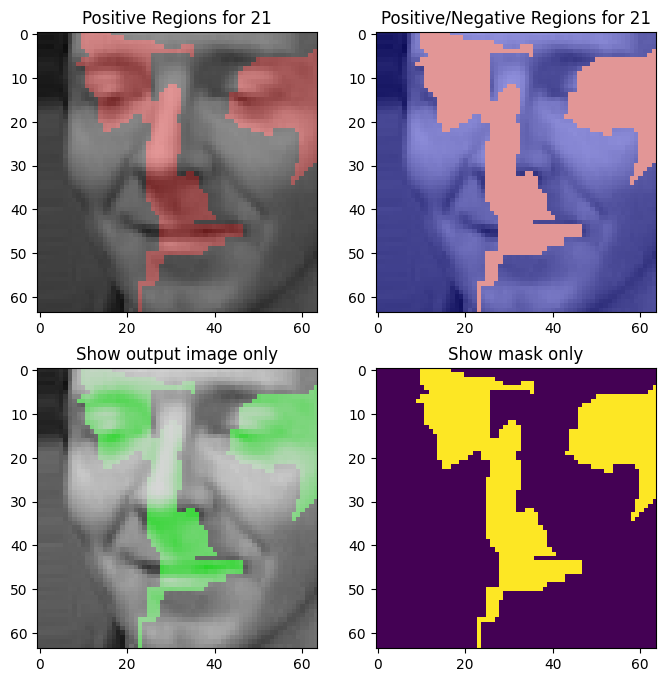

In [87]:
# 2번째 클래스가 21번째 데이터로 분류한 근거
label = exp.top_labels[1]

fig, ((ax1, ax2), (ax3, ax4))=plt.subplots(2,2,figsize=(8,8))
ax=[ax1,ax2,ax3,ax4]
for i in ax:
    i.grid(False)
# 예측에 가장 도움되는 세그먼트만 출력
temp, mask=exp.get_image_and_mask(label,
                                 positive_only=True, # 설명 모델이 결과값을 가장 잘 설명하는 이미지 영역만 출력
                                 num_features=8, # 분할 영역의 크기
                                 hide_rest=False) # 이미지를 분류하는 데 도움이 되는 서브모듈 외의 모듈도 출력
# label2rgb : 형광색 마스킹
ax1.imshow(label2rgb(mask, temp, bg_label=0), interpolation='nearest')
ax1.set_title('Positive Regions for {}'.format(label))

# 모든 세그먼트 출력
temp, mask=exp.get_image_and_mask(label,
                                 positive_only=False, # 설명 모델이 결과값을 가장 잘 설명하는 이미지 영역만 출력
                                 num_features=8, # 분할 영역의 크기
                                 hide_rest=False) # 이미지를 분류하는 데 도움이 되는 서브모듈 외의 모듈도 출력

ax2.imshow(label2rgb(4-mask, temp, bg_label=0), interpolation='nearest') # 역변환
ax2.set_title('Positive/Negative Regions for {}'.format(label))

# 이미지만 출력
ax3.imshow(temp, interpolation='nearest')
ax3.set_title('Show output image only')

# 마스크만 출력
ax4.imshow(mask, interpolation='nearest') # 정수형 array.
ax4.set_title('Show mask only') # 정수형

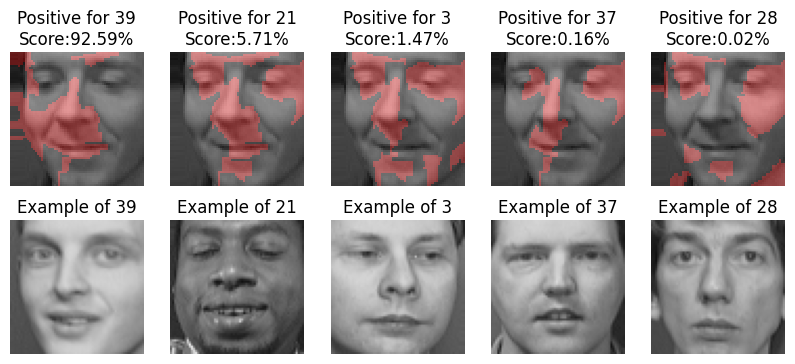

In [84]:
%matplotlib inline
fig,m_axs=plt.subplots(2,5, figsize=(10,4))

for i, (c_ax, gt_ax) in zip(exp.top_labels, m_axs.T):
    temp, mask=exp.get_image_and_mask(i,
                                         positive_only=True, # 설명 모델이 결과값을 가장 잘 설명하는 이미지 영역만 출력
                                         num_features=12, # 분할 영역의 크기
                                         hide_rest=False, # 이미지를 분류하는 데 도움이 되지 않는 세그먼트는 출력 x
                                         min_weight=0.001)
    c_ax.imshow(label2rgb(mask, temp, bg_label=0),
               interpolation='nearest')
    c_ax.set_title('Positive for {}\nScore:{:2.2f}%'.format(i,
                                                           100*y_pred[test_idx, i]))
    c_ax.axis('off')

    face_id=np.random.choice(np.where(y_train_num==i)[0])

    gt_ax.imshow(X_train[face_id])
    gt_ax.set_title('Example of {}'.format(i))
    gt_ax.axis('off')

12번째 클래스의 오분류 관련해 확인

In [88]:
np.where(y_test_num==12)

(array([ 1, 63]),)

In [89]:
olivetti_test_index=1

exp=explainer.explain_instance(X_test[olivetti_test_index], #데이터하나
                              classifier_fn=model.predict,# 40 class의 확률 반환 (softmax)
                              top_labels=5, # 확률 기준 1-5위 분석
                               num_samples=1000,# 샘플링 공간
                              segmentation_fn=segmenter) # 이전에 lime의 형식에 맞게 래핑된 분할 알고리즘

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1

In [90]:
print("LIME 설명 대상 클래스:", exp.top_labels)
label = exp.top_labels[0]
print(label)

LIME 설명 대상 클래스: [np.int64(2), np.int64(3), np.int64(28), np.int64(14), np.int64(26)]
2


Text(0.5, 1.0, 'Show mask only')

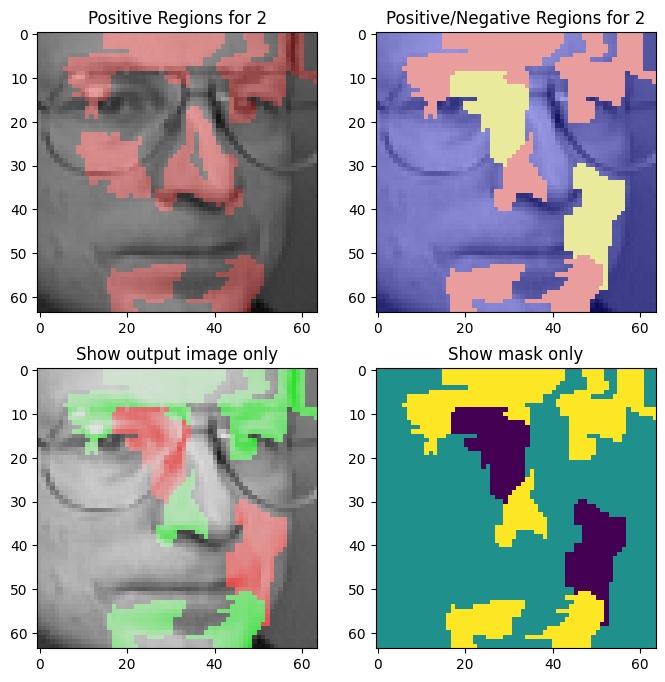

In [91]:
# 2번째 클래스가 2번째 데이터로 분류한 근거
label = exp.top_labels[0]

fig, ((ax1, ax2), (ax3, ax4))=plt.subplots(2,2,figsize=(8,8))
ax=[ax1,ax2,ax3,ax4]
for i in ax:
    i.grid(False)
# 예측에 가장 도움되는 세그먼트만 출력
temp, mask=exp.get_image_and_mask(label,
                                 positive_only=True, # 설명 모델이 결과값을 가장 잘 설명하는 이미지 영역만 출력
                                 num_features=8, # 분할 영역의 크기
                                 hide_rest=False) # 이미지를 분류하는 데 도움이 되는 서브모듈 외의 모듈도 출력
# label2rgb : 형광색 마스킹
ax1.imshow(label2rgb(mask, temp, bg_label=0), interpolation='nearest')
ax1.set_title('Positive Regions for {}'.format(label))

# 모든 세그먼트 출력
temp, mask=exp.get_image_and_mask(label,
                                 positive_only=False, # 설명 모델이 결과값을 가장 잘 설명하는 이미지 영역만 출력
                                 num_features=8, # 분할 영역의 크기
                                 hide_rest=False) # 이미지를 분류하는 데 도움이 되는 서브모듈 외의 모듈도 출력

ax2.imshow(label2rgb(4-mask, temp, bg_label=0), interpolation='nearest') # 역변환
ax2.set_title('Positive/Negative Regions for {}'.format(label))

# 이미지만 출력
ax3.imshow(temp, interpolation='nearest')
ax3.set_title('Show output image only')

# 마스크만 출력
ax4.imshow(mask, interpolation='nearest') # 정수형 array.
ax4.set_title('Show mask only') # 정수형

Text(0.5, 1.0, 'Show mask only')

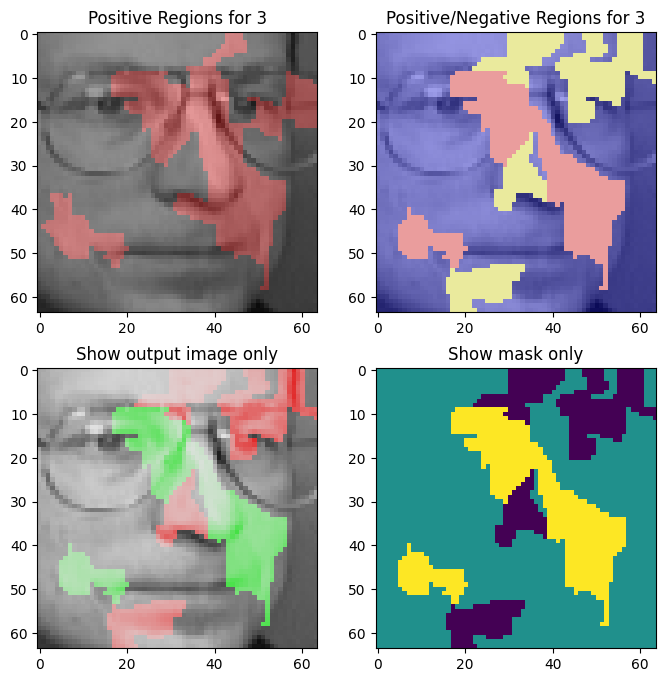

In [92]:
# 2번째 클래스가 21번째 데이터로 분류한 근거
label = exp.top_labels[1]

fig, ((ax1, ax2), (ax3, ax4))=plt.subplots(2,2,figsize=(8,8))
ax=[ax1,ax2,ax3,ax4]
for i in ax:
    i.grid(False)
# 예측에 가장 도움되는 세그먼트만 출력
temp, mask=exp.get_image_and_mask(label,
                                 positive_only=True, # 설명 모델이 결과값을 가장 잘 설명하는 이미지 영역만 출력
                                 num_features=8, # 분할 영역의 크기
                                 hide_rest=False) # 이미지를 분류하는 데 도움이 되는 서브모듈 외의 모듈도 출력
# label2rgb : 형광색 마스킹
ax1.imshow(label2rgb(mask, temp, bg_label=0), interpolation='nearest')
ax1.set_title('Positive Regions for {}'.format(label))

# 모든 세그먼트 출력
temp, mask=exp.get_image_and_mask(label,
                                 positive_only=False, # 설명 모델이 결과값을 가장 잘 설명하는 이미지 영역만 출력
                                 num_features=8, # 분할 영역의 크기
                                 hide_rest=False) # 이미지를 분류하는 데 도움이 되는 서브모듈 외의 모듈도 출력

ax2.imshow(label2rgb(4-mask, temp, bg_label=0), interpolation='nearest') # 역변환
ax2.set_title('Positive/Negative Regions for {}'.format(label))

# 이미지만 출력
ax3.imshow(temp, interpolation='nearest')
ax3.set_title('Show output image only')

# 마스크만 출력
ax4.imshow(mask, interpolation='nearest') # 정수형 array.
ax4.set_title('Show mask only') # 정수형

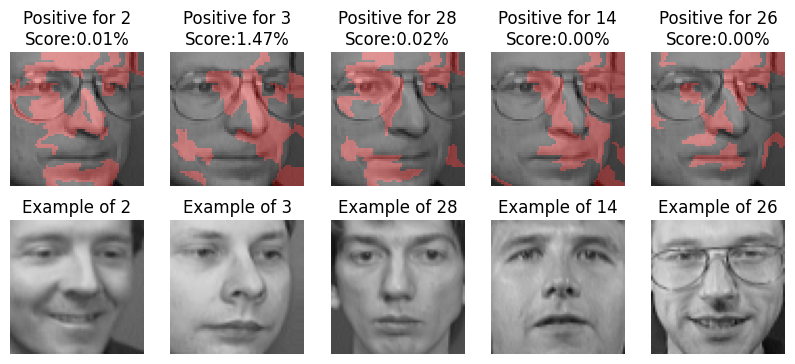

In [93]:
%matplotlib inline
fig,m_axs=plt.subplots(2,5, figsize=(10,4))

for i, (c_ax, gt_ax) in zip(exp.top_labels, m_axs.T):
    temp, mask=exp.get_image_and_mask(i,
                                         positive_only=True, # 설명 모델이 결과값을 가장 잘 설명하는 이미지 영역만 출력
                                         num_features=12, # 분할 영역의 크기
                                         hide_rest=False, # 이미지를 분류하는 데 도움이 되지 않는 세그먼트는 출력 x
                                         min_weight=0.001)
    c_ax.imshow(label2rgb(mask, temp, bg_label=0),
               interpolation='nearest')
    c_ax.set_title('Positive for {}\nScore:{:2.2f}%'.format(i,
                                                           100*y_pred[test_idx, i]))
    c_ax.axis('off')

    face_id=np.random.choice(np.where(y_train_num==i)[0])

    gt_ax.imshow(X_train[face_id])
    gt_ax.set_title('Example of {}'.format(i))
    gt_ax.axis('off')